<a href="https://colab.research.google.com/github/saleh1312/python/blob/master/football_landMarks_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as k

In [2]:
x=np.load('/content/drive/MyDrive/lands/x.npy')
y=np.load('/content/drive/MyDrive/lands/y.npy')

In [3]:
print('x shape',x.shape)
print('y shape',y.shape)

x shape (565, 320, 320, 3)
y shape (565, 29, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


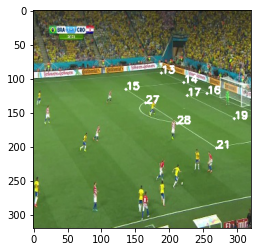

In [4]:
def plot_somepoints(x,y,i=5):
  font                   = cv2.FONT_HERSHEY_SIMPLEX
  fontScale              = 0.5
  fontColor              = (255,255,255)
  lineType               = 2
  xx=x[i].copy()/255.0
  yy=y[i]
  for p in range(29):
    x1= yy[p,0]
    y1= yy[p,1]
    if x1 < 0:
      continue
    cv2.circle(xx,(x1,y1),2,(1,1,1),-1)
    cv2.putText(xx,str(p), 
    (x1,y1), 
    font, 
    fontScale,
    fontColor,
    lineType)

  plt.imshow(xx)
plot_somepoints(x,y,477)

## resize image to 160*160 and land marks 

In [5]:
shape1 = x.shape[1]
shape2=160
f = shape1/shape2

In [6]:
x160=np.zeros((x.shape[0],160,160,3),dtype=np.uint8)
y160=np.zeros((x.shape[0],29,2),dtype=np.float32)

In [7]:
for xw in range(y.shape[0]):
  img=cv2.resize(x[xw],(160,160))
  x160[xw]=img
  for yw in range(y.shape[1]):
    if y[xw,yw,0] !=-1:
      xc1=int(np.trunc(((y[xw,yw,0])/f)))
      yc1=int(np.trunc(((y[xw,yw,1])/f)))
      y160[xw,yw,0] =xc1
      y160[xw,yw,1] =yc1
    else :
      y160[xw,yw,0] =-1
      y160[xw,yw,1] =-1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


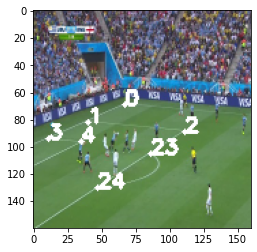

In [8]:
plot_somepoints(x160,y160,500)

## convert the land marks coordinates in the x data (320,320,3)
## to y data (80,80,30)


In [9]:
#assuing x = y axis
shape1 = x160.shape[1]
shape2 = 40
f = shape1/shape2
print(f)

4.0


In [10]:
# i will use one hot encoder in the next step
ye=np.zeros((x160.shape[0],40,40,1),dtype=np.float32)
for xw in range(y160.shape[0]):
  for yw in range(y160.shape[1]):
    if y160[xw,yw,0] !=-1:
      index=(yw+1)
      #(y[xw,yw,0]-1) -> to make land marks with zero indexing 
      xc=int(np.trunc((y160[xw,yw,0]-1)/f))
      yc=int(np.trunc((y160[xw,yw,1]-1)/f))
      ye[xw,yc,xc,0] =index

In [11]:
x160=x160.astype(np.float32)

In [12]:
print(ye.shape)
print(ye.dtype)
print(x160.shape)
print(x160.dtype)

(565, 40, 40, 1)
float32
(565, 160, 160, 3)
float32


In [13]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(ye.reshape(-1)),
                                                 ye.reshape(-1))

In [14]:
class_weight_dict = dict(enumerate(class_weights))

In [15]:
# i will use one hot encoder in the next step
we=np.zeros((ye.shape[0],40,40,1),dtype=np.float32)
for im in range(ye.shape[0]):
  for xw in range(ye.shape[1]):
    for yw in range(ye.shape[2]):
      v=ye[im,xw,yw,0]
      we[im,xw,yw,0] =class_weight_dict[v]

In [16]:
yee=to_categorical(ye,num_classes=30)

In [17]:
yd=np.concatenate((yee, we), axis=-1)

In [28]:
xe=x160.astype(np.float32)/255.0

In [19]:
input = tf.keras.layers.Input((160,160,3))
l = tf.keras.layers.Conv2D(128,(5,5),padding='same',strides=(2,2),activation='relu')(input)
l=tf.keras.layers.BatchNormalization()(l)
l=tf.keras.layers.LeakyReLU()(l)
l = tf.keras.layers.Conv2D(128,(5,5),padding='same',strides=(2,2),activation='relu')(l)
l=tf.keras.layers.BatchNormalization()(l)
l=tf.keras.layers.LeakyReLU()(l)
l = tf.keras.layers.Conv2D(64,(3,3),padding='same',activation='relu')(l)
l=tf.keras.layers.BatchNormalization()(l)
l=tf.keras.layers.LeakyReLU()(l)
l = tf.keras.layers.Conv2D(32,(3,3),padding='same',activation='relu')(l)
l=tf.keras.layers.BatchNormalization()(l)
l=tf.keras.layers.LeakyReLU()(l)
l1 = tf.keras.layers.Conv2D(30,(3,3),padding='same',activation='softmax')(l)
model=tf.keras.Model(input,l1)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 80, 128)       9728      
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 80, 128)       512       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 80, 80, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       409728    
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 40, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 40, 40, 128)       0     

In [20]:
opt1 = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [21]:
def my_loss_fn(ytrue, ypred ):
  yp=k.reshape(ypred,(-1,30))
  yt=k.reshape(ytrue[:,:,:,:-1],(-1,30))
  wed=k.reshape(ytrue[:,:,:,-1],(-1,1))
  lose1= tf.keras.losses.categorical_crossentropy(yt,yp)
  losetotal=k.sum(wed*lose1)
  return losetotal

In [ ]:
epochs =100
for e in range(epochs):
  lol =0
  kk=0
  for b in range(0,xe.shape[0],5):
    xb=xe[b:b+5]
    yb=yd[b:b+5]
    with tf.GradientTape() as tape:
      y_pred=model(xb,training=True)
      l=my_loss_fn(yb,y_pred)
    gf=tape.gradient(l,model.trainable_variables)
    opt1.apply_gradients(zip(gf,model.trainable_variables)) 
    lol = l+lol
    kk+=1
  print(e)
  print('loss',lol/kk)

### best loss is -> 2312.5 after 

60 eopch with 0.01 learining rate


60 epoch with 0.001 


15 epoch with 0.0001





In [ ]:
#model.save('/content/drive/MyDrive/lands/modelclass.h5')

In [23]:
model=tf.keras.models.load_model('/content/drive/MyDrive/lands/modelclass.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


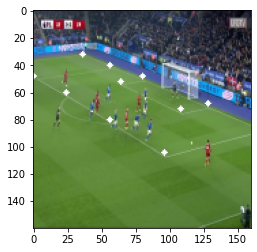

In [31]:
img=xe[200]
clas=model.predict((img.reshape((1,160,160,3))))
clase=np.argmax(clas[0],axis=-1)
cop=img.copy()
for y in range(40):
  for x in range(40):
    if clase[y,x] > 0 and clas[0,y,x,clase[y,x]] >0.6:
      yee=y*4
      xee=x*4
      cv2.circle(cop,(xee,yee),2,(255,255,255),-1)
plt.imshow(cop)